<h1><center>Local PageRank - Local similarities in the nodes of a network</center></h1>


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
# Import useful libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import networkx as nx
import time

%matplotlib inline

Name: 
Type: Graph
Number of nodes: 493
Number of edges: 1234
Average degree:   5.0061

Adjacency matrix


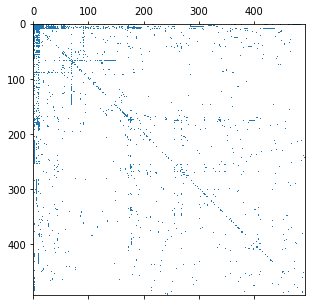


The node target is 1 and its degree is 67


In [2]:
# Import an undirected network
path = 'data/networks/as1998_500.txt'
G = nx.read_edgelist(path, delimiter='\t', nodetype=int)
A = nx.linalg.graphmatrix.adjacency_matrix(G)

# Print info of the generated Graph
print(nx.info(G))

# Plot the adjacency matrix
print('\nAdjacency matrix')
plt.figure(figsize=(5,5))
plt.spy(A, marker=',')
plt.show()

# Initialize of the node target
node_target = 1
print('\nThe node target is', node_target, 'and its degree is', G.degree(node_target))

<h3>PageRank </h3>

<p>The PageRank algorithm was developed by Sergey Brin and Lawrence Page in 1998 [1] and was later expanded into the Google search engine.<br>
The algorithm, originally develped to rank web pages, can be applyed to many different types of networks and it has been widely used and studied in the literature and in different fields. The algorithm outputs a probability distibution over the nodes of the network, computed by counting the number and the quality of links to a node to determine a rough estimate of how important the node is.</p></br>

[1] "The PageRank Citation Ranking: Bringing Order to the Web", http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf

<h3>Classical approach using the power iteration algorithm</h3>

<p>Random walk model where a web surfer is a at node <em>i</em> at time <em>t</em> with probability <em>p<sup>t,i</sup></em> and choose with equal probability one of the nodes linked by node <em>i</em> for the next time step. With a certain probability <em>1-c</em> (where <em>c</em> is called damping factor) the surfer does not jump to a linked node but to a random node according to the probability distribution provided in the teleport vector <em>q</em>. <br>
    The jump operation is performed according to the equation: p<sup>t+1</sup> = c M p<sup>t</sup> + (1-c) q <br>
where M is the adjacency matrix of the network and <em>p</em> is the probability vector. This process is iterated until convergence and the final vector <em>p</em> is the PageRank vector for the network.</p>

Elapsed time:  7.288808 seconds


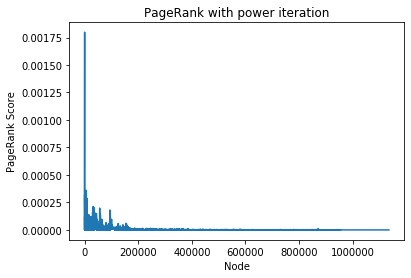

In [21]:
#compute PageRank algorithm with power iteration
def pageRank(M, q, iterations):
    N = M.shape[1]
    c = 0.85
    p = np.ones(N)/N

    for i in range(iterations):
        p = c * M * p + (1-c) * q #pagerank formula
        p = p/sum(p) #normalization

    return p


# dimension of the matrix
N = A.shape[0]

#teleport vector
# for normal pagerank all nodes have the same teleport probability
# for local pagerank only a subset of nodes have non-negative probabilty
t = np.ones(N)/N

start = time.time()
p = pageRank(A, t, 10)
stop = time.time()
print('Elapsed time: ', str(stop-start)[0:8], 'seconds')

plt.plot(p)
plt.title('PageRank with power iteration')
plt.ylabel('PageRank Score')
plt.xlabel('Node')
plt.show()

C:\Users\franc\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


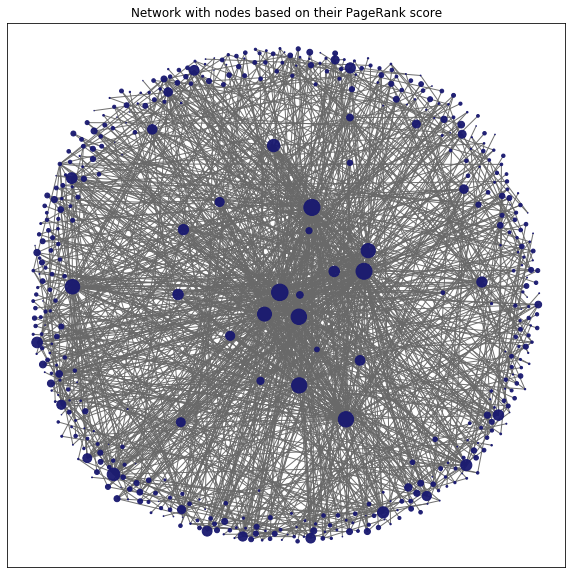

In [4]:
# Plot the network with the size of each node which corresponds to the PageRank score
plt.figure(figsize=(10,10))
plt.title('Network with nodes based on their PageRank score')
nx.draw_networkx(G, pos=nx.spring_layout(G, seed = 10, k=1.5, iterations=50),
                node_size=p*10000, linewidths=1, with_labels=False, alpha=0.95,
                node_color='midnightblue', edge_color='dimgray')
plt.show()

<h3>Personalized PageRank </h3>

<p>It is possible to introduce a bias in the random walk by setting non-zero values in the teleport set only for a given node or set of nodes. This results in a ranking of the elements in the network from the perspective of the selected nodes, this is often used for Topic Specific Pagerank and as a similarity score between nodes (SimRank).</p>

<h2><center>Task 1: Local Personalized PageRank</center</h2>

<p>In this task we implemented the Local PageRank algorithm presented in [2]. This algorithm has the advantage of having an execution time that doesn't depend on the number of nodes in the network, making it a very valid option when scalability is necessary. This result is achieved by considering only a local subset of the nodes that results in an approximated version of the PageRank.<br>
To approximate a PageRank vector pr(α, s), we compute a pair of distributions p and r with the following property. <br>
<center>p + pr(α, r) = pr(α, s). </center><br>
If p and r are two distributions with this property, we say that p is an approximate PageRank vector,
which approximates pr(α, s) with the residual vector r. <br>
Initially the vector p is set to all zeros, while the vector r is active only in the target nodes chosen. With a series of push operations, each on a single vertex u, a fraction (1-α) of the probability r(u) is moved to p(u), while the remaining is spread between the residuals of the neighbor nodes. By performing this push operation on all the nodes that satisfy the condition 
<center>r(u) / d(u) > ε </center><br>
we obtain a residual vector that satifies
<center> max <sub>u∈V</sub>   r(u) / d(u) < ε </center><br>
that is a bound on the precision of the approximation.</p></br>

[2] Andersen, Chung, Lang. 2006. Local graph partitioning using pagerank vectors. http://www.leonidzhukov.net/hse/2015/networks/papers/andersen06localgraph.pdf

In [5]:
# Input:
# - G: the graph of the network
# - target_nodes: a dictionary of target nodes with, as value, the initial residual (it can accept more than one target node)
# - alpha: the damping factor
# - epsilon: a target precision
#
# Output:
# - p: a PageRank dictionary
#
def approximatePageRank(G, target_nodes, alpha, epsilon):   

    # Initialization
    # Sum of all degrees (there is a multiplication by 2 because the graph is undirected)
    D = 2 * G.number_of_edges()

    # PageRank
    p = {}

    # Residuals
    r = target_nodes.copy()

    # Degrees
    d = {}
    for n in target_nodes:
        d[n] = G.degree(n)

    # Calculate the initial queue based on the "r / d >= epsilon" condition
    queue = [key for key in r.keys() if (d[key] > 0) and (r[key] * D >= epsilon * d[key])]

    # Iterate until the queue is not empty
    while(queue):

        # Take the first element of the queue
        node_u = queue[0]
        
        # Perform the push operation
        # Update the PageRank dictionary (if it is present we simply update it, otherwise we add it)
        if node_u in p:
            p[node_u] += (1-alpha) * r[node_u]
        else:
            p[node_u] = (1-alpha) * r[node_u]
        
        # Update the residual of the node u
        r[node_u] = alpha * r[node_u] / 2

        # Compute the new residuals of the neighbors of u
        for node_v in G.neighbors(node_u):

            # If the node is already present in the dictionary we need to
            # update it, otherwise we need to add it and compute the corresponding degree
            if node_v in r:
                r[node_v] += r[node_u] / d[node_u]
            else:
                r[node_v] = r[node_u] / d[node_u]
                d[node_v] = G.degree(node_v)

        # Recompute the queue
        queue = [key for key in r.keys() if (d[key] > 0) and (r[key] * D >= epsilon * d[key])]

    return p

In [6]:
# Input:
# - p: a pagerank dictionary
#
# Output:
# - p_V: a vector filled with zeros in the nodes not present in the dictionary
#
def arrayFromDict(p):

    # Get values and keys from the dictionary
    p_values = list(p.values())
    p_keys = np.array(list(p.keys()))

    # Normalize PageRank vector
    p_values = np.array(p_values) / sum(p_values)

    # Compute an array filling the missing nodes with zeros
    p_V = np.zeros(np.max(p_keys)+1)
    p_V[p_keys] = p_values

    return p_V

<p>The resulting vectors of the PageRank algorithm can be saved in a matrix L, such that the column <em>i</em> stores the result of the aglorithm with teleport vector active only in node <em>i</em>.</p>

In [7]:
# Input:
# - G: a graph of a network
# - alpha: damping factor
# - epsilon: the precision 
#
# Output:
# - L: the matrix L (composed by the pagerank vectors on the columns)
#
def matrix_L(G, alpha, epsilon):
    
    # Initialization
    # Number of the maximum node
    n = max(G.nodes)+1
    
    # Matrix L
    L = np.zeros((n,n))
    print('The shape of the L matrix is', L.shape)
    
    # Iterates the procedure over the nodes of increasing order
    for i in np.sort(G.nodes):

        # Init the residual of the target node
        personalization_vector = {i : 1}

        # Compute the personalized PageRank on the target node
        p = approximatePageRank(G, personalization_vector, alpha, epsilon)

        # Compute a vector from the dictionary and fill it with zeros if needed
        p = arrayFromDict(p)
        L[:,i] = np.concatenate((p, np.zeros(n-p.size)))
        
    return L

The shape of the L matrix is (11691, 11691)


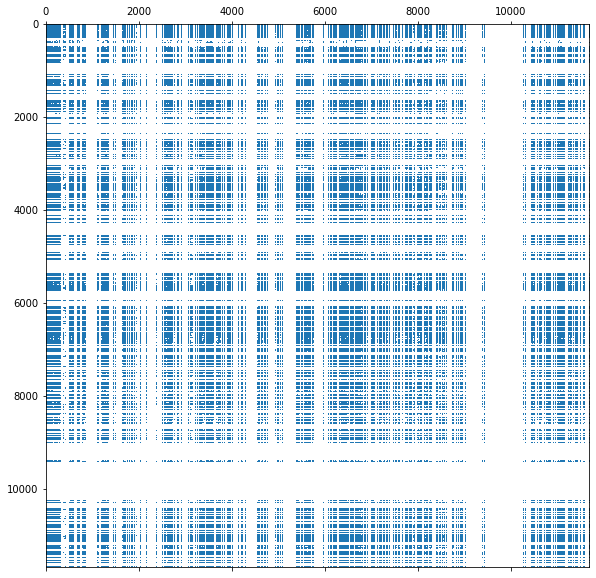

In [8]:
L = matrix_L(G, 0.85, 0.1)
plt.figure(figsize=(10,10))
plt.spy(L, marker=',')
plt.show()

<h3>Results</h3>

Now let's see how our implementation perform compared to the NetworkX implementation of the PageRank algorithm with infinite precision.

Note: from this point on, every time we use the NetworkX implementation of the PageRank we pass the damping factor $\alpha'$, $\alpha' = \frac{\alpha}{2 - \alpha}$, where $\alpha$ is the damping factor used in our implementation; this happens to account for the Lazy PageRank version chosen in the approximate algorithm.

In [9]:
# Initialize the parameters
personalization_vector = {node_target : 1}
alpha = 0.85
epsilon = 1e-2

# Compute the PageRank dictionary with our implementation
start = time.time()
p = approximatePageRank(G, personalization_vector, alpha, epsilon)
stop = time.time()
alg_time = stop - start

print('Our implementation of the Approximate PageRank')
print('Elapsed time:', str(alg_time)[0:8], 'seconds')

our_p_vector = arrayFromDict(p)

Our implementation of the Approximate PageRank
Elapsed time: 9.558262 seconds


In [10]:
# Compute the PageRank dictionary with networkx implementation
start = time.time()
p = nx.pagerank(G, personalization=personalization_vector, max_iter=20, weight=None, alpha=alpha/(2-alpha))
stop = time.time()

print('Networkx implementation of the PageRank')
print('Elapsed time:', str(stop-start)[0:8], 'seconds')

nx_p_vector = arrayFromDict(p)

Networkx implementation of the PageRank
Elapsed time: 0.319702 seconds


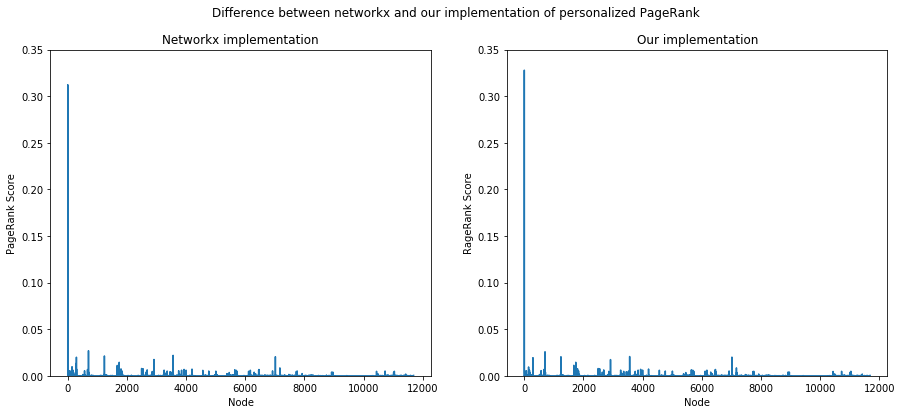

In [11]:
# Plot the difference between the two solutions
fig, axs = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Difference between networkx and our implementation of personalized PageRank')
axs[0].plot(nx_p_vector)
axs[0].set_title('Networkx implementation')
axs[0].set_ylabel('PageRank Score')
axs[0].set_xlabel('Node')
axs[0].set_ylim([0, 0.35])
axs[1].plot(our_p_vector)
axs[1].set_title('Our implementation')
axs[1].set_ylabel('RageRank Score')
axs[1].set_xlabel('Node')
axs[1].set_ylim([0, 0.35])
plt.show()

<h1><center>Task 2: Techniques to speed up the algorithm</center></h1>

<h3>Random access set</h3>

<p>Since the paper [2] does not give a specific implementation of the queue, we decided to use the simplest way to implement it. Therefore, in our first realization we used a queue which is recomputed after each push operation. Due to this fact, we keep taking the first element which satisfies the condition on the residuals, which is not efficient neither in terms of application nor considering the time spent (recreation of a queue: this can increase also with the number of nodes and it can take a long time).</br>
Trying to address these two issues, we implemented a second version of the algorithm using a set which has a random access. In this way we save time in the creation (of course it is pointless to build a new set at each push operation) and we can access a random element in the set using a simple 'pop' operation.</br>
The procedure is the same as above, the only difference is that we start with an initial set containing only the target nodes and we add a new node through the push operation (checking if it satisfies the condition on the residuals).</p>

In [12]:
# Input:
# - G: the graph of the network
# - target_nodes: a dictionary of target nodes with, as value, the initial residual (it can accept more than one target node)
# - alpha: the teleport constant
# - epsilon: a target precision
# - division_by_degree: a flag indicating whether the division by the sum of the degrees should be performed
#
# Output:
# - p: a PageRank dictionary
#
def approximatePageRank_set(G, target_nodes, alpha, epsilon, division_by_degrees):

    # Initialization
    # Sum of all degrees
    if (division_by_degrees):
        D = 2 * G.number_of_edges()
    else:
        D = 1
    
    # PageRank
    p = {}
    
    # Residuals
    r = target_nodes.copy()
    
    # Create the random access set
    s = set()
    
    # Degrees
    d = {}
    
    # Put the target nodes in the set (computing the corresponding degree)
    for n in target_nodes:
        d[n] = G.degree(n)
        s.add(n)

    # Iterate until the set is not empty
    while(len(s) > 0):
        
        # Take the first element of the set
        node_u = s.pop()

        # Get the next element if it doesn't satisfy the condition
        while(r[node_u] * D < epsilon * d[node_u]):
            node_u = s.pop()
        
        # Perform the push operation
        # Update the PageRank dictionary (if it is present we simply update it, otherwise we add it)
        if node_u in p:
            p[node_u] += (1-alpha) * r[node_u]
        else:
            p[node_u] = (1-alpha) * r[node_u]
        
        # Update the residual of the node u
        r[node_u] = alpha * r[node_u] / 2

        # Compute the new residuals of the neighbors of u
        for node_v in G.neighbors(node_u):

            # If the node is already present in the dictionary we need to
            # update it, otherwise we need to add it and compute the corresponding degree
            if node_v in r:
                r[node_v] += r[node_u] / d[node_u]
            else:
                r[node_v] = r[node_u] / d[node_u]
                d[node_v] = G.degree(node_v)
            
            # If the node v satisfy the condition we must add into the set
            if ((d[node_v] > 0) and (r[node_v] * D >= epsilon * d[node_v])):
                s.add(node_v)
        
        # After the push operation if the node still satisfy the condition
        # we have to reput into the set
        if (r[node_u] * D >= epsilon * d[node_u]):
            s.add(node_u)
        
    return p

Our implementation of the Approximate PageRank
Elapsed time: 0.164812 seconds
Computed 57.9 times faster


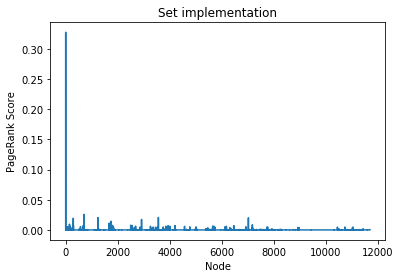

In [13]:
# Initialize the parameters
personalization_vector = {node_target : 1}
alpha = 0.85
epsilon = 1e-2

# Compute the PageRank dictionary with the set implementation
start = time.time()
p = approximatePageRank_set(G, personalization_vector, alpha, epsilon, True)
stop = time.time()

print('Our implementation of the Approximate PageRank')
print('Elapsed time:', str(stop-start)[0:8], 'seconds')
print('Computed', str(alg_time/(stop-start))[0:4], 'times faster')

set_p_vector = arrayFromDict(p)

plt.plot(set_p_vector)
plt.title('Set implementation')
plt.ylabel('PageRank Score')
plt.xlabel('Node')
plt.show()

<h3>Linear composition of Basis Vector</h3>

If we have already computed the local PageRank on all the nodes of the network, we can find the PageRank of a linear combination of two nodes by linearly combining with the same coefficients the scores of the two nodes.
$$\alpha_1 v_1 +\alpha_2 v_2 = (1 - c) A (\alpha_1 v_1 + \alpha_2 v_2) + c(\alpha_1 u_1 + \alpha_2 u_2)$$
A problem of doing this is that we need a large amount of space to save all the PageRank vectors (if a network is big), so an evolution of this approach would be to compute, through a complex procedure (described in paper [3]), a subdivision of the PageRank vectors in multiple basis-vectors and a common hub-skeleton. The main advantage is, of course, the space saved to store the latter, because the hub-skeleton is common to each PageRank vector and the partial vectors are very small (few space needed in memory).</br>
This advanced procedure is not applied here since it is out of the scope of this work. So we simply show an example with two target nodes and we demonstrate that the linear combination of the two PageRank vectors (one for each active node) works and gives the same results as the computation of the PageRank with both the nodes active.

[3] Glen Jeh and Jennifer Widom, "Scaling Personalized Web Search", http://infolab.stanford.edu/~glenj/spws.pdf

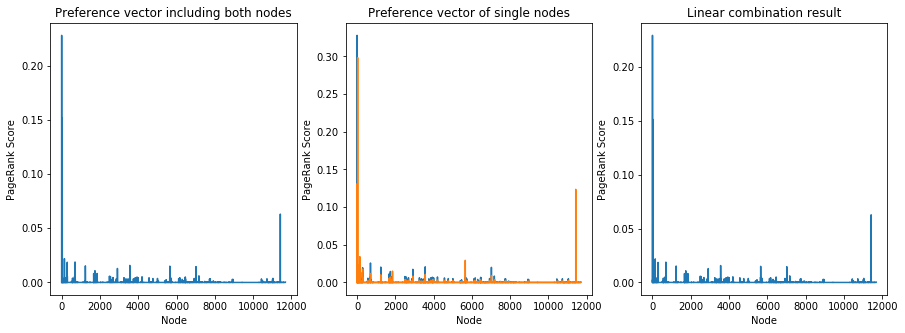

In [14]:
# Initializing the plot and some variables
fig, axs = plt.subplots(1, 3, figsize=(15,5))
personalization_vector = {1:1, 32:1}
alpha = 0.85
epsilon = 1e-2

# Compute the local PageRank with two nodes active at the same time
p = approximatePageRank_set(G, personalization_vector, alpha, epsilon, True)
combined_p = arrayFromDict(p)
axs[0].plot(combined_p)
axs[0].set_title('Preference vector including both nodes')
axs[0].set_ylabel('PageRank Score')
axs[0].set_xlabel('Node')

# Compute the local PR in the first node
p1 = approximatePageRank_set(G, {1:1}, alpha, epsilon, True)
vector_p1 = arrayFromDict(p1)
# Compute the local PR in the second node
p2 = approximatePageRank_set(G, {32:1}, alpha, epsilon, True)
vector_p2 = arrayFromDict(p2)
# Plot on the same graph the two PR vectors
axs[1].plot(vector_p1)
axs[1].plot(vector_p2)
axs[1].set_title('Preference vector of single nodes')
axs[1].set_ylabel('PageRank Score')
axs[1].set_xlabel('Node')

# Make the two vectors of the equal size filling with zeros
l = max(vector_p1.size, vector_p2.size)
if vector_p1.size > vector_p2.size:
    vector_p2 = np.append(vector_p2, np.zeros(l-vector_p2.size))
else:
    vector_p1 = np.append(vector_p1, np.zeros(l-vector_p1.size))

# Computing the linear combination and normalize the result
vector_p12 = vector_p1 + vector_p2
vector_p12 = vector_p12/sum(vector_p12)
axs[2].plot(vector_p12)
axs[2].set_title('Linear combination result')
axs[2].set_ylabel('PageRank Score')
axs[2].set_xlabel('Node')

plt.show()

<h1><center>Task 3: Scalability of the approach among different networks' dimension</center></h1>

In this section we consider four undirected and unweighted networks whith increasing number of nodes (from few thousands up to roughly one million).

Note: in this section we call our implementation of the approximate PageRank with the flag <i>division_by_degree</i> set to <i>False</i>. This happens because to test the scalability we need to match the algorithm's version proposed in paper [2]: indeed in that work the division by the sum of the degrees is not forseen, granting an approximation where $max_{u \in V} \frac{r(u)}{d(u)} < \epsilon$ (so not regarding directly the precision of the scores) and an execution time that is $O(\frac{1}{\epsilon \alpha})$, so independent on the number of nodes. In the previous sections, where we displayed the correspondence between our implementation and the one of NetworkX's library, we set this flag to <em>True</em>, since dividing by the sum of the degrees allows to have a precision on the computed scores that is less than $\epsilon$, while adding a dependence on the size of the network. So, given that here we focus on the execution time it is more appropriate to disable it, also considering tha fact that, as we can see, the obtained PageRank scores are still comparable with the precise ones.

In [15]:
# select the node target
node_target = 100

# initialize the list with the stats
nodes_vector = [0] * 4
our_times_vector = [0] * 4
nx_times_vector = [0] * 4

# init some parameters
personalization_vector = {node_target : 1}
alpha = 0.85
epsilon = 1e-6

Name: 
Type: Graph
Number of nodes: 7440
Number of edges: 27794
Average degree:   7.4715

Our implementation of ApproximatePageRank of the node 100
Elapsed time: 0.489710 seconds
Networkx implementation of PageRank
Elapsed time: 6.015582 seconds



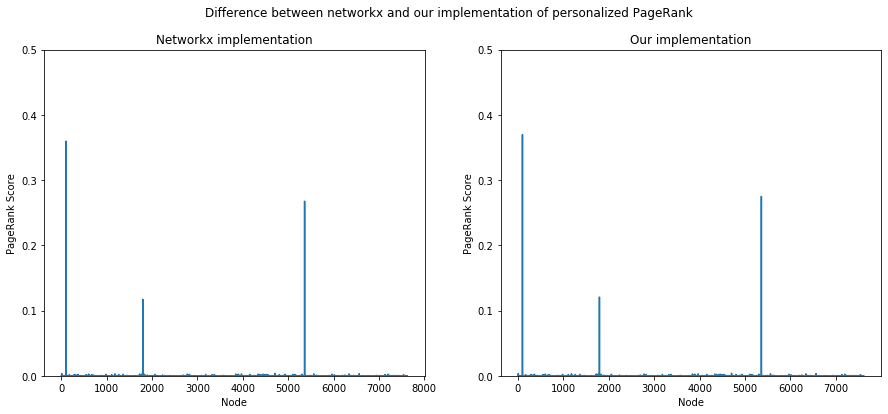

In [16]:
# Import a network with about 7k nodes
path = 'data/networks/lastfm_asia_7000.csv'
G = nx.read_edgelist(path, delimiter=',', nodetype=int)
A = nx.linalg.graphmatrix.adjacency_matrix(G)
print(nx.info(G))
print()

# Save the number of nodes
nodes_vector[0] = G.number_of_nodes()

# Compute our Personalized PageRank and save the execution time
start = time.time()
p = approximatePageRank_set(G, personalization_vector, alpha, epsilon, False)
stop = time.time()
t = str(stop-start)[0:8]
our_times_vector[0] = float(t)
print('Our implementation of ApproximatePageRank of the node', node_target)
print('Elapsed time:', t, 'seconds')
p_vector = arrayFromDict(p)

# Compute networkx PageRank and save the execution time
start = time.time()
pr = nx.pagerank(G, personalization=personalization_vector, max_iter=20, weight=None, alpha=alpha/(2-alpha))
stop = time.time()
t = str(stop-start)[0:8]
nx_times_vector[0] = float(t)
print('Networkx implementation of PageRank')
print('Elapsed time:', t, 'seconds\n')
pr_vector = arrayFromDict(pr)

# Plot the difference between the two solutions
fig, axs = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Difference between networkx and our implementation of personalized PageRank')
axs[0].plot(pr_vector)
axs[0].set_title('Networkx implementation')
axs[0].set_ylabel('PageRank Score')
axs[0].set_xlabel('Node')
axs[0].set_ylim([0, 0.5])
axs[1].plot(p_vector)
axs[1].set_title('Our implementation')
axs[1].set_ylabel('PageRank Score')
axs[1].set_xlabel('Node')
axs[1].set_ylim([0, 0.5])
plt.show()

Name: 
Type: Graph
Number of nodes: 22470
Number of edges: 171002
Average degree:  15.2205

Our implementation of ApproximatePageRank of the node 100
Elapsed time: 0.756526 seconds
Networkx implementation of PageRank
Elapsed time: 29.25123 seconds



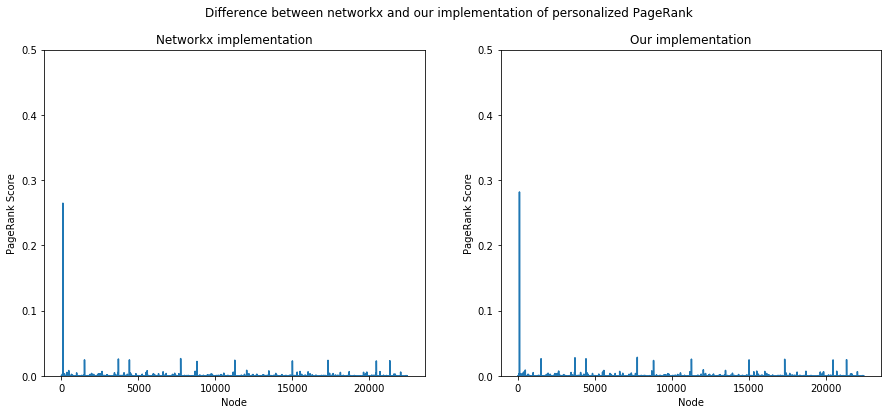

In [17]:
# Import a network with about 22k nodes
path = 'data/networks/musae_facebook_22000.csv'
G = nx.read_edgelist(path, delimiter=',', nodetype=int)
A = nx.linalg.graphmatrix.adjacency_matrix(G)
print(nx.info(G))
print()

# Save the number of nodes
nodes_vector[1] = G.number_of_nodes()

# Compute our Personalized PageRank and save the execution time
start = time.time()
p = approximatePageRank_set(G, personalization_vector, alpha, epsilon, False)
stop = time.time()
t = str(stop-start)[0:8]
our_times_vector[1] = float(t)
print('Our implementation of ApproximatePageRank of the node', node_target)
print('Elapsed time:', t, 'seconds')
p_vector = arrayFromDict(p)

# Compute networkx PageRank and save the execution time
start = time.time()
pr = nx.pagerank(G, personalization=personalization_vector, max_iter=20, weight=None, alpha=alpha/(2-alpha))
stop = time.time()
t = str(stop-start)[0:8]
nx_times_vector[1] = float(t)
print('Networkx implementation of PageRank')
print('Elapsed time:', t, 'seconds\n')
pr_vector = arrayFromDict(pr)

# Plot the difference between the two solutions
fig, axs = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Difference between networkx and our implementation of personalized PageRank')
axs[0].plot(pr_vector)
axs[0].set_title('Networkx implementation')
axs[0].set_ylabel('PageRank Score')
axs[0].set_xlabel('Node')
axs[0].set_ylim([0, 0.5])
axs[1].plot(p_vector)
axs[1].set_title('Our implementation')
axs[1].set_ylabel('PageRank Score')
axs[1].set_xlabel('Node')
axs[1].set_ylim([0, 0.5])
plt.show()

Name: 
Type: Graph
Number of nodes: 334863
Number of edges: 925872
Average degree:   5.5299

Our implementation of ApproximatePageRank of the node 100
Elapsed time: 0.873849 seconds
Networkx implementation of PageRank
Elapsed time: 83.14592 seconds



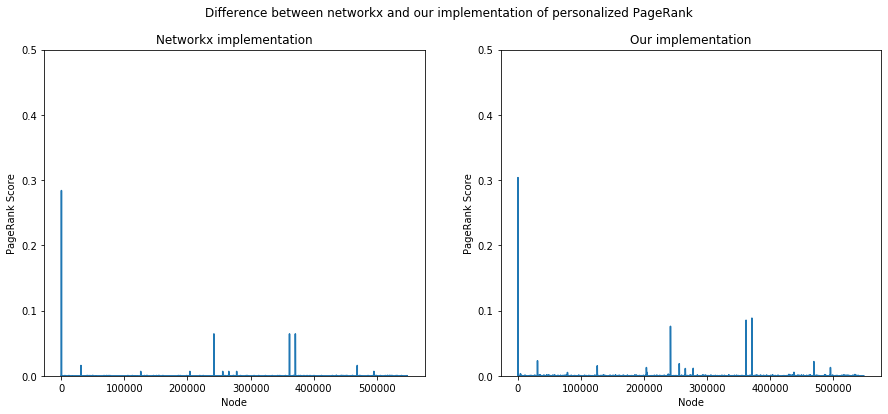

In [18]:
# Import a network with about 335k nodes
path = 'data/networks/amazon_335000.txt'
G = nx.read_edgelist(path, delimiter='\t', nodetype=int)
A = nx.linalg.graphmatrix.adjacency_matrix(G)
print(nx.info(G))
print()

# Save the number of nodes
nodes_vector[2] = G.number_of_nodes()

# Compute our Personalized PageRank and save the execution time
start = time.time()
p = approximatePageRank_set(G, personalization_vector, alpha, epsilon, False)
stop = time.time()
t = str(stop-start)[0:8]
our_times_vector[2] = float(t)
print('Our implementation of ApproximatePageRank of the node', node_target)
print('Elapsed time:', t, 'seconds')
p_vector = arrayFromDict(p)

# Compute networkx PageRank and save the execution time
start = time.time()
pr = nx.pagerank(G, personalization=personalization_vector, max_iter=20, weight=None, alpha=alpha/(2-alpha))
stop = time.time()
t = str(stop-start)[0:8]
nx_times_vector[2] = float(t)
print('Networkx implementation of PageRank')
print('Elapsed time:', t, 'seconds\n')
pr_vector = arrayFromDict(pr)

# Plot the difference between the two solutions
fig, axs = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Difference between networkx and our implementation of personalized PageRank')
axs[0].plot(pr_vector)
axs[0].set_title('Networkx implementation')
axs[0].set_ylabel('PageRank Score')
axs[0].set_xlabel('Node')
axs[0].set_ylim([0, 0.5])
axs[1].plot(p_vector)
axs[1].set_title('Our implementation')
axs[1].set_ylabel('PageRank Score')
axs[1].set_xlabel('Node')
axs[1].set_ylim([0, 0.5])
plt.show()

Name: 
Type: Graph
Number of nodes: 1134890
Number of edges: 2987624
Average degree:   5.2650

Our implementation of ApproximatePageRank of the node 103
Elapsed time: 1.033964 seconds
Networkx implementation of PageRank
Elapsed time: 311.6733 seconds



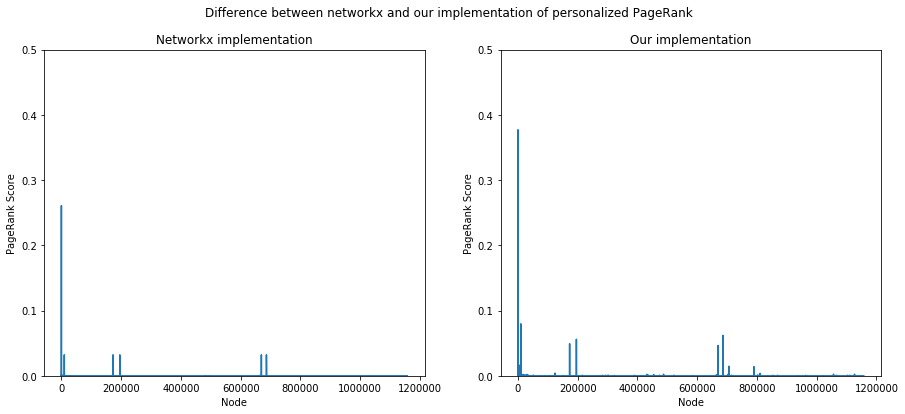

In [19]:
# select the node target
node_target = 103

# init the residual of the target node
personalization_vector = {node_target : 1}

# Import a network with about 1135k nodes
path = 'data/networks/youtube_1135000.txt'
G = nx.read_edgelist(path, delimiter='\t', nodetype=int)
A = nx.linalg.graphmatrix.adjacency_matrix(G)
print(nx.info(G))
print()

# Save the number of nodes
nodes_vector[3] = G.number_of_nodes()

# Compute our Personalized PageRank and save the execution time
start = time.time()
p = approximatePageRank_set(G, personalization_vector, alpha, epsilon, False)
stop = time.time()
t = str(stop-start)[0:8]
our_times_vector[3] = float(t)
print('Our implementation of ApproximatePageRank of the node', node_target)
print('Elapsed time:', t, 'seconds')
p_vector = arrayFromDict(p)

# Compute networkx PageRank and save the execution time
start = time.time()
pr = nx.pagerank(G, personalization=personalization_vector, max_iter=20, weight=None, alpha=alpha/(2-alpha))
stop = time.time()
t = str(stop-start)[0:8]
nx_times_vector[3] = float(t)
print('Networkx implementation of PageRank')
print('Elapsed time:', t, 'seconds\n')
pr_vector = arrayFromDict(pr)

# Plot the difference between the two solutions
fig, axs = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Difference between networkx and our implementation of personalized PageRank')
axs[0].plot(pr_vector)
axs[0].set_title('Networkx implementation')
axs[0].set_ylabel('PageRank Score')
axs[0].set_xlabel('Node')
axs[0].set_ylim([0, 0.5])
axs[1].plot(p_vector)
axs[1].set_title('Our implementation')
axs[1].set_ylabel('PageRank Score')
axs[1].set_xlabel('Node')
axs[1].set_ylim([0, 0.5])
plt.show()

<h3>Graph of the scalability</h3>

<p>We plot here the execution time needed for both the algorithms over the increasing number of nodes and we can observe an important fact: our algorithm's execution time is practically independent of the network dimension, while the NetworkX PageRank with infinite precision is linearly dependent from it.</p>

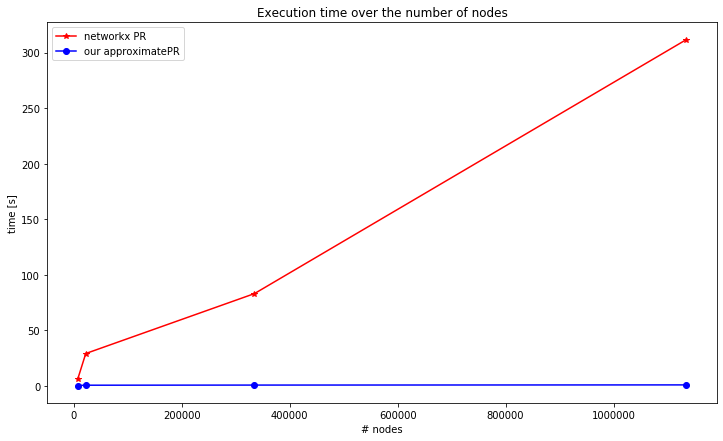

In [22]:
# Plot the execution time over the number of the nodes of both the implementation
plt.figure(figsize=(12,7))
plt.plot(nodes_vector, nx_times_vector, 'r*-', label='networkx PR')
plt.plot(nodes_vector, our_times_vector, 'bo-', label='our approximatePR')
plt.title('Execution time over the number of nodes')
plt.xlabel('# nodes')
plt.ylabel('time [s]')
plt.legend()
plt.show()